In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn import datasets, linear_model
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import sklearn.metrics
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import FormatStrFormatter
from google.colab import files
from matplotlib.ticker import PercentFormatter

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


We read in the dataframe and clean out the column names

In [ ]:
df = pd.read_csv('Final-Sample-External-with-ISINs.csv')

column_list = []
for column in df.columns:
    column_list.append(column.replace(' ', ''))
df.columns = column_list

Format columns from the csv to float.

In [ ]:
df = df[['Year', 'Country', 'Industry(Exiobase)', 'EnvironmentalIntensity(Sales)', 'TotalEnvironmentalCost']]

def percent_to_float(s):
    return float(s.strip('%')) / 100.0

df['EnvironmentalIntensity(Sales)'] = df['EnvironmentalIntensity(Sales)'].apply(percent_to_float)

replace_dict = {'(':'',')':'', ' ' : '', ',' : ''}
def paranthesis_to_minus(value):
    for i, j in replace_dict.items():
        value = value.replace(i, j)
    value = int(f'-{value}')
    return value

df['TotalEnvironmentalCost'] = df['TotalEnvironmentalCost'].apply(paranthesis_to_minus)

Create dummy variables for industry and country and get countries that contain more than 2 companies in order to remove outliers.

In [ ]:
df = pd.get_dummies(df, columns = ['Industry(Exiobase)', 'Country'])

columns_3 = ['EnvironmentalIntensity(Sales)', 'TotalEnvironmentalCost']

for column in df.columns:
  if df[column].sum(axis = 0) > 2:
    columns_3.append(column)

# df = df[columns_3]

x = df.drop(columns = ['Year',  'EnvironmentalIntensity(Sales)', 'TotalEnvironmentalCost'])
y = df['EnvironmentalIntensity(Sales)']

Setup the dataframe to fit into the models. Fit the models

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
OLS_VS = sm.OLS(y_train, x_train).fit().summary() #48.2 percent of the variation can be explained with this model

print(OLS_VS)
# y_pred = OLS_VS.predict(x_test)
# r2_score(y_test, y_pred)

OLS_CV = linear_model.LinearRegression()
lasso = linear_model.Lasso()
ridge = linear_model.Ridge()

OLS_CV.fit(x_train, y_train)
y_pred = OLS_CV.predict(x_test)
r2_score(y_test, y_pred)

print( 'OLS:', cross_val_score(OLS_CV, x_train, y_train, cv=3, scoring = 'r2').mean())
print('Lasso:', cross_val_score(lasso, x_train, y_train, cv=3, scoring = 'r2').mean())
print('Ridge:', cross_val_score(ridge, x_train, y_train, cv=3, scoring = 'r2').mean())

# XGBoost
dtrain = xgb.DMatrix(x_train, label = y_train)
dtest = xgb.DMatrix(x_test, label = y_test)

param = {'max_depth': 2, 'eta': 1}
param['nthread'] = 4
param['eval_metric'] = 'auc'

evallist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 10
# bst = xgb.train(param, dtrain, num_round, evallist)


#Random Forest
X, y = make_regression(n_features=4, n_informative=2,
                       random_state=0, shuffle=False)
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(x_train, y_train)

y_pred = regr.predict(x_test)
print('Random Forest:', r2_score(y_test, y_pred))


                                  OLS Regression Results                                 
Dep. Variable:     EnvironmentalIntensity(Sales)   R-squared:                       0.475
Model:                                       OLS   Adj. R-squared:                  0.464
Method:                            Least Squares   F-statistic:                     43.55
Date:                           Thu, 06 May 2021   Prob (F-statistic):               0.00
Time:                                   00:06:27   Log-Likelihood:                 2371.2
No. Observations:                          11612   AIC:                            -4268.
Df Residuals:                              11375   BIC:                            -2524.
Df Model:                                    236                                         
Covariance Type:                       nonrobust                                         
                                                                                                    

While OLS and Lasso seem to give negative results, meaning the fit is actually worse than just fitting a horizontal line which is why the R-square is negative. 

Ridge and Random Forest models explained 43% and 22% respeectively. The summary of these models can be found below:

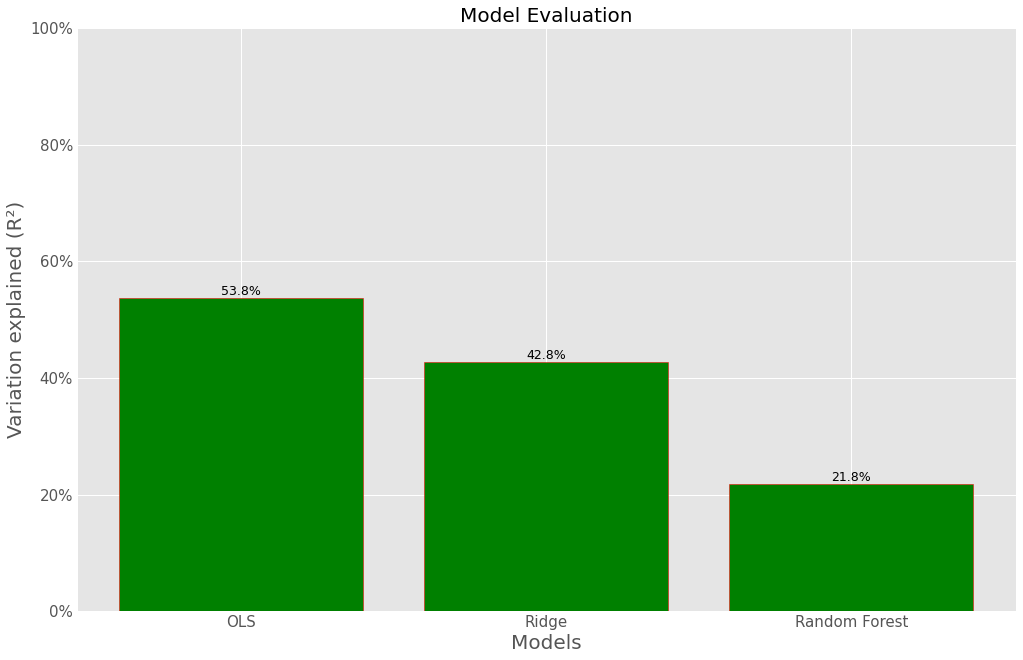

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
x = ['OLS', 'Ridge', 'Random Forest']
y = [53.8, 42.8, 21.8]

# plt.style.use('green')

fig, ax = plt.subplots(figsize=(15,10))
ax.yaxis.set_major_formatter(PercentFormatter())
bars = ax.bar(x, y, color=['green'],  edgecolor='red')
# ax.xticks()
ax.set_xlabel('Models', fontsize = 20)
ax.set_ylabel('Variation explained (R\u00b2)', fontsize = 20)
ax.set_ylim(0, 100)
ax.set_xticklabels(x, fontsize= 15)
ax.set_title('Model Evaluation', fontsize= 20)
for bar in bars:
  height = bar.get_height()
  label_x_pos = bar.get_x() + bar.get_width() / 2
  ax.text(label_x_pos, height, s=f'{height}%', ha='center',
  va='bottom', fontsize = 12.5)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15) 

plt.show()
fig.savefig("abc.png")
files.download("abc.png") 